In [1]:
# Import Packages
# utilities
import re
import numpy as np
import pandas as pd
import string
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve

#
import warnings
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [2]:
# Import Data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("scraped.csv") 

# Basic Exploratory Data Analysis

In [3]:
# Data visualizations in the other file

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


- Based on above information, we can see there are some missing values for column "keyword" and "location".
- We think that location is not quite helpful in predicting disaster-related tweets. Thus, we will drop the "location" column in the following analysis

In [5]:
# Drop "location" column
df_train = df_train.drop("location", axis = 1)
df_test = df_test.drop("location", axis = 1)

In [6]:
df_train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- "location" column has been dropped successfully

In [7]:
# Fill in missing values
df_train.fillna(method='ffill',inplace=True)
df_train.fillna('no',inplace=True)

df_test.fillna(method='ffill',inplace=True)
df_test.fillna('no',inplace=True)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7613 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


- All missing values are filled successfully with -999

In [10]:
# Check dups
dups = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
dups = dups[dups['target'] > 1]
dups

,id,keyword,target
text,,,
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2,2,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2,1,2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6,1,2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,2,1,2
To fight bioterrorism sir.,4,1,2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,3,1,2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,3,1,2
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,3,1,2
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6,1,2


- There are several duplicates in the data, so we need to drop duplicates

In [11]:
df_train = df_train.drop_duplicates(subset=['text'])

In [12]:
df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)

,id,keyword,target
text,,,
! Residents Return To Destroyed Homes As Washington Wildfire Burns on http://t.co/UcI8stQUg1,1,1,1
Obama Declares Disaster for Typhoon-Devastated Saipan: http://t.co/M6LvKXl9ii,1,1,1
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/lEYJwNnAH8,1,1,1
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/a1MoeJxqyA,1,1,1
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/XDt4VHFn7B,1,1,1
...,...,...,...
Back from Seattle Tacoma and Portland. Whirlwind! http://t.co/qwHINBni8e,1,1,1
Baby elephant dies just days after surviving massacre of his family http://t.co/qzCUT7bVKT,1,1,1
BUT I will be uploading these videos ASAP so you guys get to see the new weapon types in action!,1,1,1


- Now, there is no duplicate in the training data

# Data Preprocessing

We need to do tweet text cleaning along with normal text pre-processing as a tweet may contains
- URL's
- Mentions
- Hashtags
- Emojis
- Special Characters etc.

To clean the tweet, we can use a python library tweet-preprocessor instead of writing the cleaning logic ourself.

In [13]:
import preprocessor as p

In [14]:
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    return text

In [15]:
df_train['text'] = df_train.apply(preprocess_tweet, axis=1)

In [16]:
df_train.head()

,id,keyword,text,target
0,1,no,Our Deeds are the Reason of this May ALLAH For...,1
1,4,no,Forest fire near La Ronge Sask. Canada,1
2,5,no,All residents asked to 'shelter in place' are ...,1
3,6,no,people receive evacuation orders in California,1
4,7,no,Just got sent this photo from Ruby as smoke fr...,1


### Now, we need to do normal preprocessing like:
- Stopwords removal
- Punctuation Removal
- Extra white Spaces Removal
- Lowercasing

In [17]:
# Stopwords removal
from gensim.parsing.preprocessing import remove_stopwords

def stopword_removal(row):
    text = row['text']
    text = remove_stopwords(text)
    return text

In [18]:
df_train['text'] = df_train.apply(stopword_removal, axis = 1)

In [19]:
# Remove Extra white spaces, punctuation and apply lowercasing
df_train['text'] = df_train['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

In [20]:
df_train.head()

,id,keyword,text,target
0,1,no,our deeds reason may allah forgive,1
1,4,no,forest near la ronge sask canada,1
2,5,no,all residents asked shelter place notified off...,1
3,6,no,people receive evacuation orders california,1
4,7,no,just got sent photo ruby smoke pours school,1


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7503 non-null   int64 
 1   keyword  7503 non-null   object
 2   text     7503 non-null   object
 3   target   7503 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 293.1+ KB


In [204]:
# Get X and y
X_train = df_train.drop(['target'],axis=1)
y_train = df_train.target

In [169]:
X_train.head()

,keyword,text
0,no,our deeds reason may allah forgive
1,no,forest near la ronge sask canada
2,no,all residents asked shelter place notified off...
3,no,people receive evacuation orders california
4,no,just got sent photo ruby smoke pours school


In [170]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [171]:
y_train.value_counts()

0    4305
1    3198
Name: target, dtype: int64

- Above information shows a 50-50 distribution of 0 and 1 outcomes in the training set, which indicates the dataset is approximately balanced.

# SVM

In [205]:
# Split training set into train and val data
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train, y_train, 
                                                  test_size=0.3,random_state=0)

In [209]:
X_val_svm

,id,keyword,text
3054,4382,earthquake,earthquake drill atm
4065,5777,forest%20fires,inciweb or update rogue river siskiyou nationa...
4431,6304,hostage,you held hostage radical group
6208,8858,smoke,you re dating doesn t let smoke leave date smo...
7305,10455,wild%20fires,i thinking today i reading wild fires
...,...,...,...
4414,6274,hijacking,funtenna hijacking computers send data sound w...
2020,2899,damage,lmao fuckboy changed damage control
1043,1509,body%20bags,lab today ready body bags
1171,1688,bridge%20collapse,icymi australia collapse trent bridge twitter ...


In [178]:
train_vectors_count_svm = count_vectorizer.fit_transform(X_train_svm['text'])
test_vectors_count_svm = count_vectorizer.transform(X_val_svm["text"])

In [179]:
from sklearn.svm import SVC
SVM = SVC()
SVM.fit(train_vectors_count_svm, y_train_svm)
y_pred_svm = SVM.predict(test_vectors_count_svm)

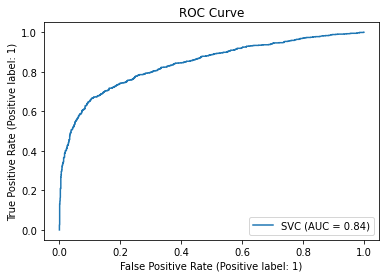

In [180]:
plot_roc_curve(SVM, test_vectors_count_svm, y_val_svm)
plt.title("ROC Curve")
plt.show()

# MLP

In [116]:
from sklearn.neural_network import MLPClassifier

In [181]:
# Split training set into train and val data
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_train, y_train, 
                                                  test_size=0.3,random_state=0)

In [182]:
train_vectors_count_mlp = count_vectorizer.fit_transform(X_train_mlp['text'])
test_vectors_count_mlp = count_vectorizer.transform(X_val_mlp["text"])

In [255]:
MLP = MLPClassifier(solver='lbfgs', alpha=1e-4,
                     hidden_layer_sizes=(6, 4), random_state=1)

In [256]:
MLP.fit(train_vectors_count_mlp, y_train_mlp)

/Users/tianluo/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(6, 4), random_state=1, solver='lbfgs')

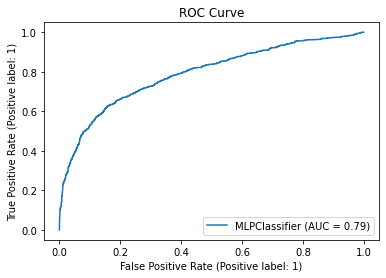

In [329]:
plot_roc_curve(MLP, test_vectors_count_mlp, y_val_mlp)
plt.title("ROC Curve")
plt.show()

# Knn

In [366]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [367]:
# Split training set into train and val data
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_train, y_train, 
                                                  test_size=0.3,random_state=0)

In [368]:
train_vectors_count_knn = count_vectorizer.fit_transform(X_train_knn['text'])
test_vectors_count_knn = count_vectorizer.transform(X_val_knn["text"])

In [369]:
def grid_search_knn(X_train, Y_train):
    #grid searching
    neighbors = list(range(1,50,1))

    param_grid = {
        'n_neighbors' : neighbors
    }

    clf = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    #print(grid_search.cv_results_)
    print(grid_search.best_params_)
    return grid_search.best_params_
    return grid_search.best_params_

In [370]:
def knn(X_train, Y_train, X_test, Y_test, params):
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    plot_roc_curve(knn, test_vectors_count_knn, y_val_knn)
    plt.title("ROC Curve")
    plt.show()

{'n_neighbors': 3}


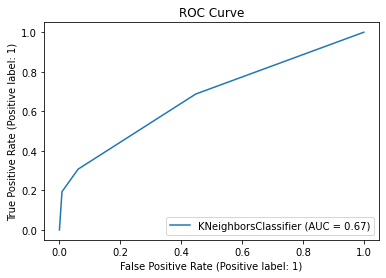

In [374]:
params = grid_search_knn(train_vectors_count_knn, y_train_knn)
knn(train_vectors_count_knn, y_train_knn, test_vectors_count_knn, y_val_knn, params)

# Real time tweet data prediction with SVM

In [299]:
df_test.head()

,Unnamed: 0,keyword,Text
0,0,rescue,and escape did wasn t taken no bothered look ...
1,1,storm,tactical covert box messenger backpack storm
2,2,sinking,men stepped closer pushed weight shears sinki...
3,4,accident,like start ogs dying off ive self spoiled acc...
4,5,injuries,men dwarrow different interpretation gender s...


In [307]:
df_test = df_test.dropna(subset=['Text'])

In [308]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18922 entries, 0 to 18922
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18922 non-null  int64 
 1   keyword     18922 non-null  object
 2   Text        18922 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.3+ KB


In [309]:
test_vectors_count_svm = count_vectorizer.transform(df_test["Text"])
y_pred_final = SVM.predict(test_vectors_count_svm)

In [311]:
df_test['prediction'] = pd.DataFrame(y_pred_final)

In [313]:
df_test.to_csv("final_pred.csv",index=False)

# Performance in Kaggle Competition

In [375]:
df_test_ka = pd.read_csv("test.csv")

In [377]:
df_test_ka = df_test_ka.drop(["keyword","location"],axis=1)

In [379]:
df_test_ka['text'] = df_test_ka.apply(preprocess_tweet, axis=1)
df_test_ka['text'] = df_test_ka.apply(stopword_removal, axis = 1)
df_test_ka['text'] = df_test_ka['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

In [382]:
df_test_ka

,id,text
0,0,just happened terrible car crash
1,2,heard different cities stay safe everyone
2,3,forest spot pond geese fleeing street i save
3,9,apocalypse lighting
4,11,typhoon soudelor kills china taiwan
...,...,...
3258,10861,earthquake safety los angeles safety fasteners...
3259,10865,storm ri worse hurricane my city amp 3others h...
3260,10868,green line derailment chicago
3261,10874,meg issues hazardous weather outlook hwo


In [384]:
test_vectors_count_kaggle = count_vectorizer.transform(df_test_ka["text"])
y_pred_ka = SVM.predict(test_vectors_count_kaggle)

In [387]:
df_ka = pd.DataFrame(y_pred_ka)

In [388]:
df_ka.columns=["target"]

In [385]:
final_id=store_id(df_test_ka)

In [389]:
df_ka["id"]=final_id

In [390]:
df_ka.to_csv("ka.csv",index=False)

# Kaggle Competition score is 0.8